# Analysis Workflow: Spectral Fitting

The GBM Data Tools has a module designed for spectral fitting. As discussed, GBM data can be prepared and exported for use in XSPEC and other fitting packages.  To provide a full experience with GBM data, we also provide a way to fit GBM data by extending and wrapping standard optimizers provided in [scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html).  In fact, we can pretty easily leverage complicated optimization algorithms that can use imposed bounds and constraints on parameters, and we allow the user to decide if they want to use a more or less complex fitting procedure (of course we have suggestions!). The spectral fitting class can be extended to use various likelihoods, and can even be extended to perform a Bayesian analysis and posterior sampling (although we haven't directly implemented it yet). We don't want to get too much into the weeds here, but we'll briefly mention areas of note as we go along.  

The previous section on export for use in XSPEC was a bit simplified in that we only looked at a single detector for analysis, and typically we'll want to jointly fit multiple detectors that have good viewing of the source.  This means that for each detector you're using, you need to multiply all your steps in the previous section by the number of detectors.  What a slog!  So to help reduce the amount of repetitive work we have to do, we can use the `GbmDetectorCollection` class.  If we add our data to this "collection," then we can easily perform operations on all items in the collection.  There are great benefits to doing this as we will find out shortly.

Let's look at CSPEC data this time:

In [1]:
from gbm import test_data_dir
from gbm.data import Cspec, GbmDetectorCollection

# Load some CSPEC files for a GRB
n0 = Cspec.open(test_data_dir+'/160509374/glg_cspec_n0_bn160509374_v01.pha')
n1 = Cspec.open(test_data_dir+'/160509374/glg_cspec_n1_bn160509374_v01.pha')
b0 = Cspec.open(test_data_dir+'/160509374/glg_cspec_b0_bn160509374_v01.pha')

# create a collection from the list of our files
cspecs = GbmDetectorCollection.from_list([n0, n1, b0])

Now that you know the general process of fitting the background, selecting the time and energy ranges, and plotting, we'll go ahead and define these ranges here.  One thing to note is that we are using both NaI and BGO detectors.  That means we need to be using the appropriate energy ranges for the detectors.

In [2]:
# define some time and energy ranges
view_range = (-33.0, 102.0) # zoom in to this time range
bkgd_range = [(-550., -300.), (675., 1000.)] # the background fit ranges
src_range = (14.0, 17.0)    # our time selection
erange_nai = (8.0, 900.0) # in keV
erange_bgo = (325, 35000.0)

Let's perform our background fits.  Second-order polynomials for all of them, unless we decide they need to be adjusted:

In [3]:
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial

# initialize the fitters and add to collection, making sure the collection knows which background
# goes with which detector
backfitters = [BackgroundFitter.from_phaii(cspec, Polynomial, time_ranges=bkgd_range) for cspec in cspecs]
backfitters = GbmDetectorCollection.from_list(backfitters, dets=cspecs.detector())

# do the fit
backfitters.fit(order=2)

# interpolate/extrapolate and store in a collection
bkgds = backfitters.interpolate_bins(cspecs.data()[0].tstart, cspecs.data()[0].tstop)
bkgds = GbmDetectorCollection.from_list(bkgds, dets=cspecs.detector())

Ok, we actually just did a lot on a few lines, so let's recap and explain.  We created a background fitter for each detector's data and added the fitters to their own collection.  We also made sure that we tagged the background fitters to correspond to the correct detectors.  This will be vitally important in a minute. So, instead of having to call `backfitter.fit()` for each backfitter, we can call that method on the collection, and it performs the operation on *every item in the collection*.  Cool.  This works if you have the same arguments to be applied to each item.  What if for one detector, you want to fit a 1st-order polynomial?  We'd suggest a list comprehension, similar to:
```python
[backfitter.fit(order=poly_order) for backfitter, poly_order in zip(backfitters, poly_orders)]
```
So you can definitely iterate over the collection like a list, but there is a lot of convenience for easily performing the same operation on a collection of data objects.

After performing the fit, we interpolate each backfitter over an array of times.  The array of times we use is actually just the bin times from the first CSPEC file we added to the collection.  This is fine because all our data are binned to the same bin edges.  Then we add these interpolated backgrounds to their own collection.

Now we need to apply our selections, especially if we want to make a few plots and not go blindly into dark:

In [4]:
# the lightcurves
data_lcs = cspecs.to_lightcurve(nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})
# the energy-integrated background
bkgd_lcs = bkgds.integrate_energy(nai_args=erange_nai, bgo_args=erange_bgo)
# the source time selection
src_lcs = cspecs.to_lightcurve(time_range=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})

# the count spectrum
data_specs = cspecs.to_spectrum(time_range=src_range)
# the time-integrated background
bkgd_specs = bkgds.integrate_time(*src_range)
# the energy selection
src_specs = cspecs.to_spectrum(time_range=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})

We just massively leveraged the collections to avoid having to write loops or list comprehensions.  ***And*** we were able to treat the NaI and BGO energy selections *all in one line* for each set of lightcurves or spectra.  Notice the `nai_args`, `nai_kwargs`, and the corresponding bgo arguments?  Those allow us to specify arguments and keywords to be passed to either NaI or BGO detectors.  Something like the `time_range` is the same for both detector types, so we pass it like a normal keyword as the object method expects, but `energy_range` is detector-type-dependent, since we usually want different energy ranges for the different types of detectors.  Can you implement this in a loop over the separate objects instead?  Sure, but your code will be at least 2x as long and harder to follow.

Whew.  Now time to plot:

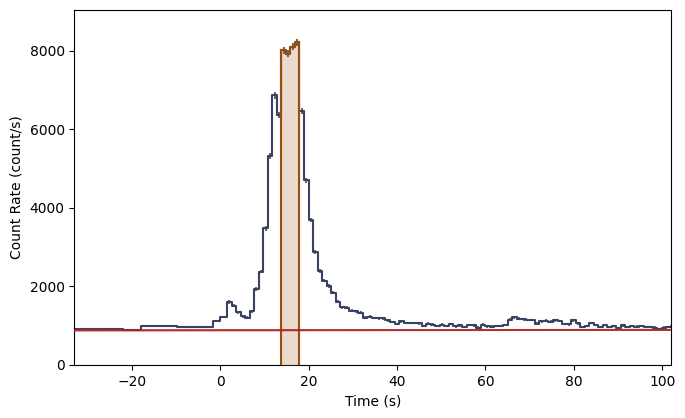

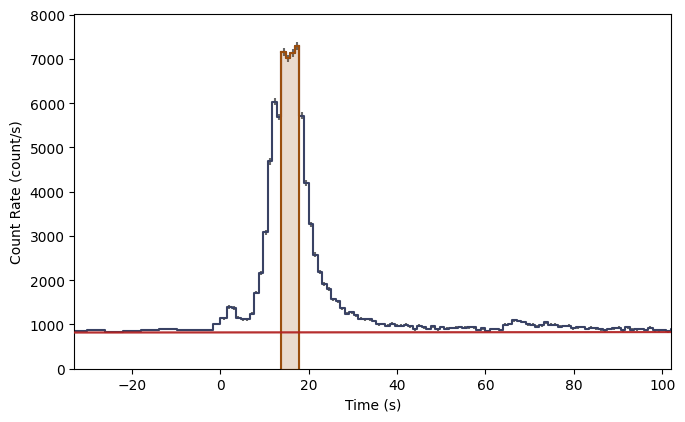

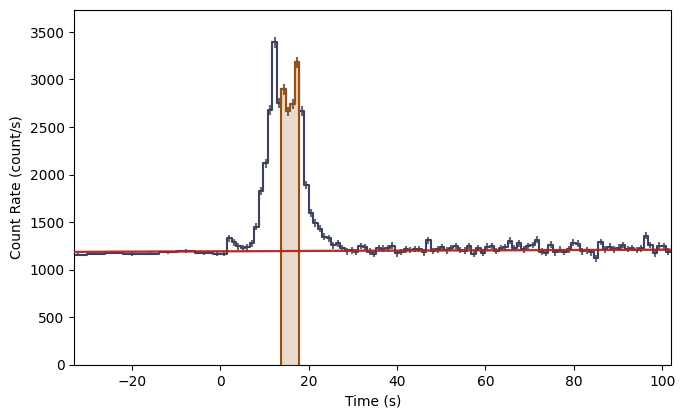

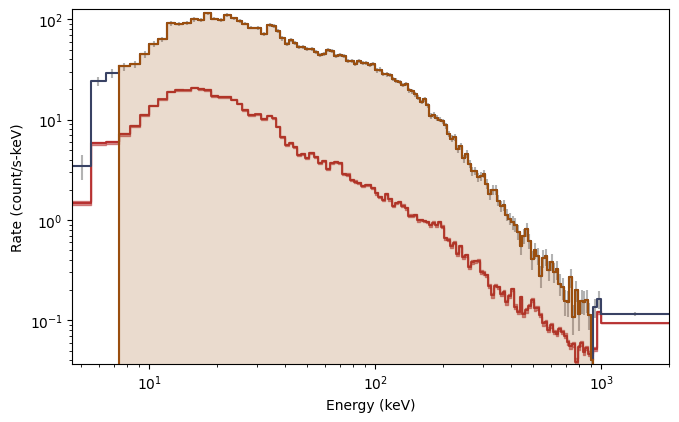

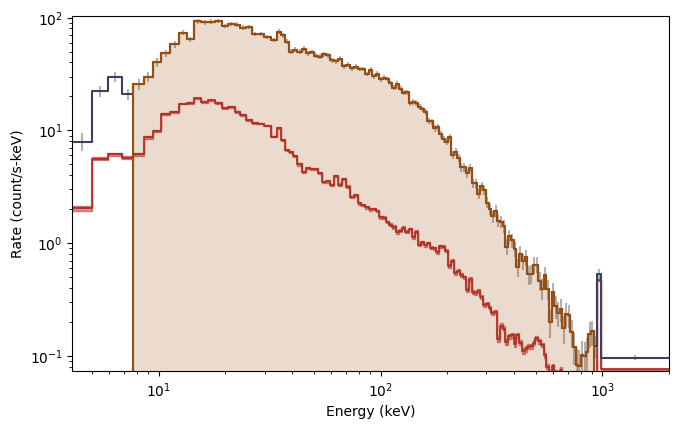

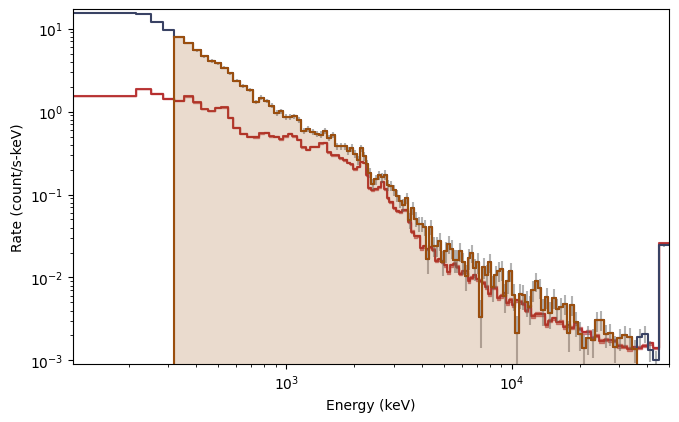

In [5]:
%matplotlib inline
from gbm.plot import Lightcurve, Spectrum

# Plot the lightcurves with the selections and background fit
lcplots = [Lightcurve(data=data_lc, background=bkgd_lc) for data_lc, bkgd_lc in zip(data_lcs, bkgd_lcs)]
_ = [lcplot.add_selection(src_lc) for lcplot, src_lc in zip(lcplots, src_lcs)]
# zoom in
for lcplot in lcplots:
    lcplot.xlim = view_range
 
# Plot the spectra with the selections and background fit
specplots = [Spectrum(data=data_spec, background=bkgd_spec) for data_spec, bkgd_spec in zip(data_specs, bkgd_specs)]
_ = [specplot.add_selection(src_spec) for specplot, src_spec in zip(specplots, src_specs)]

What you see are the three lightcurves of the three data files, and the three corresponding count spectra.  We need to create PHAs and responses similar to the previous workflow.  Let's choose to interpolate the responses.

In [6]:
from gbm.data import RSP
phas = cspecs.to_pha(time_ranges=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})

# open responses
rsp1 = RSP.open(test_data_dir+'/160509374/glg_cspec_n0_bn160509374_v00.rsp2')
rsp2 = RSP.open(test_data_dir+'/160509374/glg_cspec_n1_bn160509374_v00.rsp2')
rsp3 = RSP.open(test_data_dir+'/160509374/glg_cspec_b0_bn160509374_v00.rsp2')
rsps = GbmDetectorCollection.from_list([rsp1, rsp2, rsp3])

# and interpolate response files to get DRMs at center of the source window
rsps_interp = [rsp.interpolate(pha.tcent) for rsp, pha in zip(rsps, phas)]

Everything we've done so far is only slightly more complicated than the previous workflow, but we got the chance to demo working with collections of detectors.  If you haven't had fun yet, you will now.

As mentioned, the spectral fitting class (```SpectralFitter```) is built on top of scipy's optimization algorithms, and therefore you can directly specify which algorithm you want to use and the various arguments/settings that go along with it. Additionally, there are various derived classes of ```SpectralFitter``` that implement a specific likelihood function.  For GBM data, you will most likely want to use pgstat (Profile-Gaussian likelihood), and therefore you would use the ```SpectralFitterPgstat``` fitter.  There are other likelihoods avaliable, like chi-squared, and of course you can make your own.

In [7]:
from gbm.spectra.fitting import SpectralFitterPgstat

# we initialize with our PHAs, backgrounds, and responses:
specfitter = SpectralFitterPgstat(phas, bkgds.to_list(), rsps.to_list(), method='TNC')

You'll notice the 'TNC' method defined.  This is the [Truncated Newton algorithm](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-tnc.html#optimize-minimize-tnc), which performs optimization considering the boundaries and constraints on your parameters.

Now you need to select a function to fit.  A whole tutorial could probably be devoted to the functionality of the functions, but let's make this as simple as possible.  The ```gbm.spectra.functions``` module contains a listing of functions with a variety of metadata attached to them.  Essentially for each parameter of a function, you can set basic defaults (like in XSPEC), such as the starting guess values for parameters, their min/max bounds, and if they are fixed or free to be fit. This allows them to be used with the more complex algorithms like TNC. What's cool is that you can easily make one of your own functions that inherit all this functionality (pun intended).  But let's worry about that later, and import a few standard functions:

In [8]:
# a power law, cut-off power law, and a Band function
from gbm.spectra.functions import PowerLaw, Comptonized, Band

# instantiate a Band function
band = Band()

You can easily see what the parameter listing is for your function:

In [9]:
band.param_list

[('A', 'ph/s/cm^2/keV', 'Amplitude'),
 ('Epeak', 'keV', 'SED Peak'),
 ('alpha', '', 'Low-Energy Photon index'),
 ('beta', '', 'High-Energy Photon index'),
 ('Epiv', 'keV', 'Pivot energy')]

And similarly, the default values, minimum/maximum allowable values, etc.:

In [10]:
print(band.default_values)
print(band.min_values)
print(band.max_values)

[0.01, 500.0, -0.5, -2.5, 100.0]
[1e-10, 0.01, -1.9, -10.0, 0.01]
[inf, inf, 20.0, -2.0001, inf]


That was painless.  Now let's fit it.  Remember that you can use any of the options and settings for the scipy optimizer you chose.  We can also print out some relevant info to make sure the fit succeeded, and if it did, we can quickly access things like the best-fit parameters and parameter uncertainties at the xx% confidence level. 

In [11]:
print('Band Fit:')
specfitter.fit(band, options={'maxiter': 1000})

# After the fit has converged, we can query the fitter for lots of info, including the parameters that
# satisfy the maximum likelihood as well as the parameter uncertainties resulting from -2(Delta)LogLike
print(specfitter.message)
print('Parameters: {}'.format(specfitter.parameters))
print('90% Asymm. Errors:\n {}'.format(specfitter.asymmetric_errors(cl=0.9)))
print('Pgstat/DoF: {}/{}'.format(specfitter.statistic, specfitter.dof))

Band Fit:
Converged (|f_n-f_(n-1)| ~= 0)
Parameters: [ 3.06953043e-01  3.13978720e+02 -7.60642875e-01 -2.19161093e+00]
90% Asymm. Errors:
 [[3.71213297e-03 3.74687465e-03]
 [5.52273992e+00 5.66382428e+00]
 [1.53509429e-02 1.57720638e-02]
 [5.00633717e-02 4.59141731e-02]]
Pgstat/DoF: 277.3252207934582/358


[Hey hey!](https://youtu.be/m7p3kqpiTts?t=1) We've successfully completed our first fit!  It converged, and we printed out (in ugly print) the maximum likelihood parameter values and 90% confidence uncertainties, which are calculated from the shape of the likelihood surface.  We also output the fit statistic and the fit degrees of freedom.

This is nice, but as always, a plot is worth a 1000 words.  We can use the ```ModelFit``` class from the ```gbm.plot``` module to view the fit:

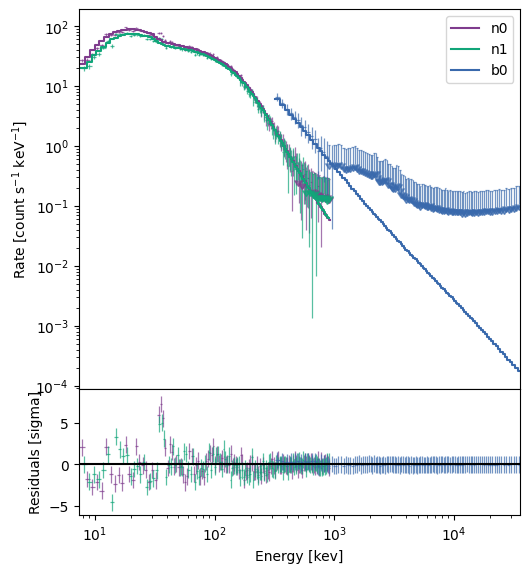

In [12]:
from gbm.plot import ModelFit

# initialize with your spectral fitter once the fit is done
modelplot = ModelFit(fitter=specfitter)

The default view of the model plot shows the fit of the Band function to the count spectrum.  The data are converted to upper limits based on the model variances, and that seems to largely happen above a few hundred keV.  The residual plot shows significant deviation around the [Iodine K-edge](https://en.wikipedia.org/wiki/K-edge), which usually only rears its ugly head for very bright spectra. If you're concerned about how the K-edge affects the fit, you can always select energy ranges that omit ~30-40 keV.

If you're feeling good about your fit, you can also switch views to plot the resulting photon, energy, or $\nu F_\nu$ spectrum:

/Users/amgoldst/Desktop/gbm-data-tools/gbm/spectra/fitting.py:601: RuntimeWarning: covariance is not positive-semidefinite.
  **kwargs)


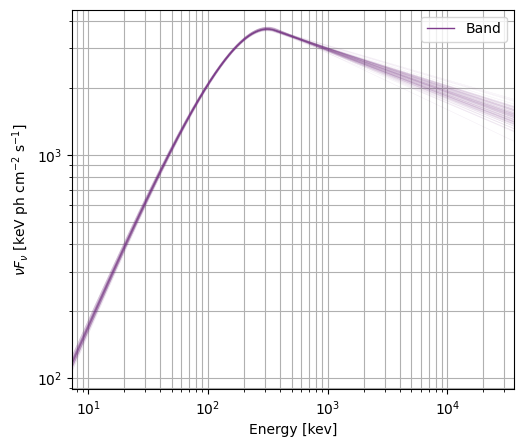

In [13]:
modelplot = ModelFit(fitter=specfitter, view='nufnu')
modelplot.ax.grid(which='both')

The model plot samples from the covariance matrix to produce a density plot of the spectrum.  A word of caution here: you don't always have a valid covariance matrix that is symmetric and positive semi-definite (and will be alerted if this is the case), so you should investigate the parameter posteriors further, perhaps with MCMC or nested sampling.

You can quickly get the flux for the best-fit parameters using ```band.integrate()``` or produce samples (again using the covariance matrix) using ```specfitter.sample_flux()```:

In [14]:
# flux over 10-1000 keV
photon_flux = band.integrate(specfitter.parameters, (10.0, 1000.0)) # photons/s/cm^2
energy_flux = band.integrate(specfitter.parameters, (10.0, 1000.0), energy=True) # erg/s/cm^2
photon_flux, energy_flux

(73.03416490430172, 1.4720268196516327e-05)

You can always rerun the fit with a different function if you want.  Let's have a little fun and perform a multi-component fit.  Another feature of the functions are that you can elegantly add or multiply components into a single model.

In [15]:
# we've defined a new model that is the sum of a Comptonized function and a power law
comp_pl = Comptonized() + PowerLaw()

# rerun the fit
print('Comp+PL Fit:')
specfitter.fit(comp_pl, options= {'maxiter': 1000})

print(specfitter.message)
print('Parameters: {}'.format(specfitter.parameters))
print('Pgstat/DoF: {}/{}'.format(specfitter.statistic, specfitter.dof))

Comp+PL Fit:
Converged (|f_n-f_(n-1)| ~= 0)
Parameters: [ 2.54578195e-01  3.79044937e+02 -8.10083989e-01  1.30777519e-02
 -1.36467487e+00]
Pgstat/DoF: 352.50370024792556/357


Cool, that fit converged as well.  What does the fit look like?

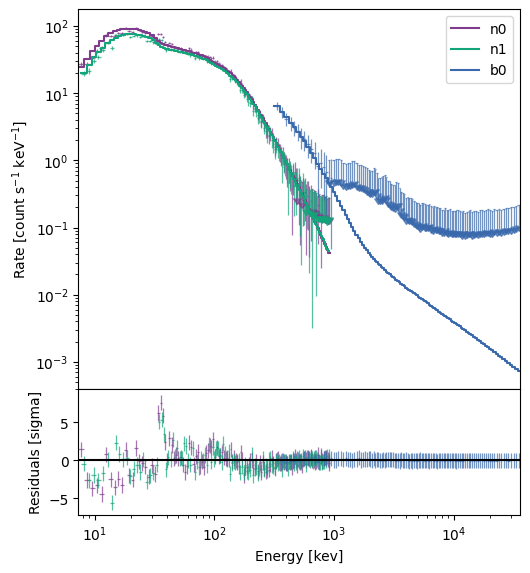

In [16]:
modelplot = ModelFit(fitter=specfitter)

You can tell the residuals at < 30 keV are a little worse than for the Band function (and the PG-stat is higher), but at least it let us demo the multi-component functionality.  To round it out, let's just take a look at the $\nu F_\nu$ spectrum.

/Users/amgoldst/Desktop/gbm-data-tools/gbm/spectra/fitting.py:601: RuntimeWarning: covariance is not positive-semidefinite.
  **kwargs)


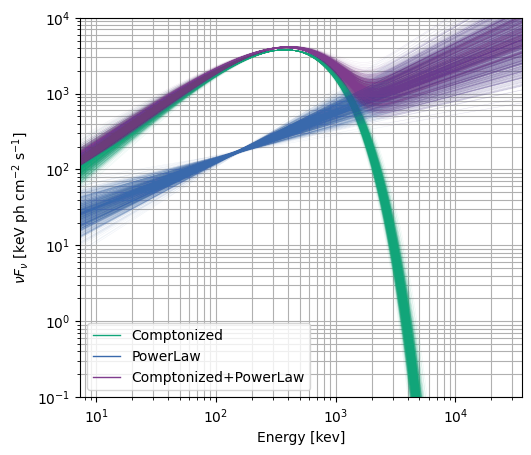

In [17]:
modelplot = ModelFit(fitter=specfitter)
# plot 1000 samples instead of the default 100
modelplot.nufnu_spectrum(num_samples=1000)
modelplot.ylim = (0.1, 10000.0)
modelplot.ax.grid(which='both')

And finally, to finish up the workflow, we can save the entire state of the fitter and fit results for later:
```python 
specfitter.save('./my_second_fit.npz')
```
This will save everything to a compressed numpy file, which can be loaded at any time with
```python
restored_specfitter = SpectralFitterPgstat.load('./my_second_fit.npz')
```

This concludes the workflow example for spectral fitting. Continue on for a brief tutorial on the interface to the GBM [Spectral Catalog files](./ScatFiles.ipynb)